In [1]:
#=======================================
# Imports
#=======================================
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray
import datetime
import calendar
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib
import pickle
import pandas as pd
import os
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.interpolate import NearestNDInterpolator as nn
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from metpy.calc import dry_lapse, lcl, moist_lapse
import metpy.calc as mpcalc
from metpy.units import units
import scipy
from dask.distributed import Client
import h5py
import time
from scipy.integrate import cumulative_trapezoid as scitrapz

from IPython.display import display, clear_output


In [2]:
#=======================================
# Diagnostics Parameters
#=======================================
space = '    '
#=======================================
# Functions
#=======================================
def print_diag(key,var):
    print(key)
    print(space,'Shape:',np.shape(var))
    print(space,'Max:',np.max(var))
    print(space,'Min:',np.min(var))
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

# Input parameters

In [3]:
bin_path = '/discover/nobackup/mwstanfo/dharma_3d/cntl_bin/'
file_name='dharma_3d_cntl_bin_038400.nc'
ncfile = xarray.open_dataset(bin_path+file_name,decode_times=False)
pc_radius_02 = ncfile['pc_radius_02'].values
pc_rbound_02 = ncfile['pc_rbound_02'].values
ncfile.close()

# Dictionaries for 3D variables and cloud-top variables

In [4]:
def main(file,micro_scheme):
    """
    For a single file (i.e., time), read in some variables and
    calculate water contents, integrated water contents (water paths),
    and then send variables to the 'calc_cth' function.
    
    Returns a dictionary with all desired variables.
    """
    
    #print('Reading in file...')
    # Read in file
    ncfile = xarray.open_dataset(file,decode_times=False)
    pres = ncfile['pressure'].values*1.e-2 # in hPa
    rho = ncfile['rhobar'].values # in kg/m^3
    qcloud = ncfile['qc'].values # in kg/kg
    qrain = ncfile['qr'].values # in kg/kg
    qnrain = ncfile['nr'].values # in kg/kg
    reff_c = ncfile['reff_c'].values # in /kg
    qncloud = ncfile['nc'].values # in /kg
    z = ncfile['zt'].values # in m
    w = ncfile['w_interp'].values # in m
    xtime = ncfile['time'].values[0] # seconds
    temp = ncfile['temperature'].values-273.15 # deg C
    #nx = ncfile.dims['nx']
    #ny = ncfile.dims['ny']
    #nz = ncfile.dims['nzt']
    nx = ncfile.sizes['nx']
    ny = ncfile.sizes['ny']
    nz = ncfile.sizes['nzt']
    x = ncfile.coords['x'].values
    y = ncfile.coords['y'].values
    #qvapor = ncfile['qv'].values # kg/kg
    zw = ncfile['zw'].values
    dz = np.diff(zw)
    num_bins = 50
    
    rwc = qrain*rho*1.e3 # g/m^3
    clwc = qcloud*rho*1.e3 # g/m^3
    lwc = rwc + clwc
    #print('Time (seconds):',xtime)
    #radius = pc_radius_02 # um
    #rbound = pc_rbound_02 # um

    clwp = np.trapezoid(clwc,z) # g/m^2
    rwp = np.trapezoid(rwc,z) # g/m^2
    lwp = np.trapezoid(lwc,z) # g/m^2
    
    dharma_dict = {'qcloud':qcloud,\
                   'rho':rho,\
                   'qrain':qrain,\
                   'qncloud':qncloud,\
                   'qnrain':qnrain,\
                   'z':z,\
                   'w':w,\
                   'time':xtime,\
                   'temp':temp,\
                   'nx':nx,\
                   'ny':ny,\
                   'nz':nz,\
                   'x':x,\
                   'y':y,\
                   'reff_c':reff_c,\
                   'dz':dz,\
                   'num_bins':num_bins,\
                   'lwp':lwp,\
                   'clwp':clwp,\
                   'rwp':rwp,\
                  }
    
    
    return dharma_dict

In [5]:
def get_dsd_params(dharma_dict,micro_scheme):
    """
    Calculates DSD parameters, adds them to the dictionary, and returns the dictionary.
    """
    #========================================================
    # Parameters for gamma distributions
    #========================================================
    qsmall = 1.e-14
    const_PI     = 3.14159265358979323846
    const_rhol   = 1.e3 # density of liquid water 

    # Cloud water
    disp = 0.3 # from input parameter file

    pgamc = 1./disp**2. - 1.
    pgamc = max(  2., pgamc )
    pgamc = min( 30., pgamc )
    gam4s1 = (pgamc+3.)*(pgamc+2.)*(pgamc+1)
    gam1c = scipy.special.gamma(pgamc + 1.)
    gam4c = scipy.special.gamma(pgamc + 4.)
    lamc_min = (pgamc+1.)/60.e-6
    lamc_max = (pgamc+1.)/1.e-6
    
    
    # Rain
    lamr_min = 1./2800.e-6
    lamr_min_hm = 1./2800.e-6
    lamr_max = 1./20.e-6
    lamr_max_hm = 1./20.e-6
    
    gamr_fix = 3.
    pgamr = gamr_fix

    gam1r = scipy.special.gamma(pgamr + 1.)
    gam4r = scipy.special.gamma(pgamr + 4.)
    #========================================================
    
    nz = dharma_dict['nz']

    dharma_dict['lam_c'] = np.zeros((dharma_dict['nx'],dharma_dict['ny'],nz))-999.
    dharma_dict['n0_c'] = np.zeros((dharma_dict['nx'],dharma_dict['ny'],nz))-999.
    dharma_dict['log_n0_c'] = np.zeros((dharma_dict['nx'],dharma_dict['ny'],nz))-999.
    dharma_dict['lam_r'] = np.zeros((dharma_dict['nx'],dharma_dict['ny'],nz))-999.
    dharma_dict['n0_r'] = np.zeros((dharma_dict['nx'],dharma_dict['ny'],nz))-999.
    dharma_dict['log_n0_r'] = np.zeros((dharma_dict['nx'],dharma_dict['ny'],nz))-999.
    dharma_dict['reff_r'] = np.zeros((dharma_dict['nx'],dharma_dict['ny'],nz))-999.
        
        
    for kk in range(nz):

        qcloud = dharma_dict['qcloud'][:,:,kk] # kg/kg
        qncloud = dharma_dict['qncloud'][:,:,kk] # /kg
        qrain = dharma_dict['qrain'][:,:,kk] # kg/kg
        qnrain = dharma_dict['qnrain'][:,:,kk] # /kg

            
        cloud_id = np.where(qcloud > qsmall)
        rain_id = np.where((qrain > qsmall) & (qnrain > qsmall) )

        #======================================
        # Cloud
        #======================================
        lam_c = np.zeros((dharma_dict['nx'],dharma_dict['ny']))-999.
        n0c = np.zeros((dharma_dict['nx'],dharma_dict['ny']))-999.
        log_n0c = np.zeros((dharma_dict['nx'],dharma_dict['ny']))-999.

        # Calculate Lambda
        lam_c[cloud_id] = ( const_PI*const_rhol*qncloud[cloud_id]*gam4s1 / (6.*qcloud[cloud_id]) )**(1./3.)
        
        # Lambda Limits
        min_id = np.where((lam_c < lamc_min) & (qcloud > qsmall))
        if np.size(min_id) > 0.:
            lam_c[min_id] = lamc_min
            
        max_id = np.where(lam_c > lamc_max)
        if np.size(max_id) > 0.:
            lam_c[max_id] = lamc_max

      

        # Calculate N0
        log_n0c[cloud_id] = np.log((qncloud[cloud_id])*dharma_dict['rho'][kk]) + (pgamc + 1.)*np.log(lam_c[cloud_id]) - np.log(gam1c)
        n0c[cloud_id] = np.exp(log_n0c[cloud_id])
        dharma_dict['lam_c'][:,:,kk] = lam_c
        dharma_dict['n0_c'][:,:,kk] = n0c
        dharma_dict['log_n0_c'][:,:,kk] = log_n0c


        #======================================
        # Rain
        #======================================
        lam_r = np.zeros((dharma_dict['nx'],dharma_dict['ny']))-999.
        n0r = np.zeros((dharma_dict['nx'],dharma_dict['ny']))-999.
        log_n0r = np.zeros((dharma_dict['nx'],dharma_dict['ny']))-999.
        mri = np.zeros((dharma_dict['nx'],dharma_dict['ny']))-999.
        Dmr = np.zeros((dharma_dict['nx'],dharma_dict['ny']))-999.
        reff_r = np.zeros((dharma_dict['nx'],dharma_dict['ny']))-999.

        lamr_min = lamr_min_hm
        lamr_max = lamr_max_hm
            
        if micro_scheme == 'SB':

            mri_min  = lamr_min**3./(const_PI*const_rhol)
            mri_max  = lamr_max**3./(const_PI*const_rhol)

            mri[rain_id] = qnrain[rain_id]/qrain[rain_id]
            dumid = np.where( (qrain > qsmall) & (mri > mri_max))
            mri[dumid] = mri_max
            dumid = np.where( (qrain > qsmall) & (mri < mri_min))
            mri[dumid] = mri_min


            Dmr[rain_id] = ( 6. / (const_PI*const_rhol*mri[rain_id]) )**(1./3.)
            gam4s1_r = (pgamr+3.)*(pgamr+2.)*(pgamr+1.)
            lam_r[rain_id] = gam4s1_r**(1./3.)/Dmr[rain_id]
            
            for ii in range(len(qrain[:,0])):
                for jj in range(len(qrain[0,:])):
                    if qrain[ii,jj] > qsmall:
                        lam_r[ii,jj] = max( lamr_min*(gam4s1_r/6.)**(1./3.), lam_r[ii,jj] )
                        lam_r[ii,jj] = min( lamr_max*(gam4s1_r/6.)**(1./3.), lam_r[ii,jj] )
            

            log_n0r[rain_id] = np.log((qnrain[rain_id])*dharma_dict['rho'][kk]) + (pgamr+1.)*np.log(lam_r[rain_id]) - np.log(gam1r)
            n0r[rain_id] = np.exp(log_n0r[rain_id])
            reff_r[rain_id] = 1.e6*(pgamr+3.)/lam_r[rain_id]/2.
            dharma_dict['lam_r'][:,:,kk] = lam_r
            dharma_dict['n0_r'][:,:,kk] = n0r
            dharma_dict['log_n0_r'][:,:,kk] = log_n0r
            dharma_dict['reff_r'][:,:,kk] = reff_r

        elif micro_scheme == 'KK':
            lam_r[rain_id] = ( const_PI*const_rhol*qnrain[rain_id]/qrain[rain_id])**(1./3.)

            # Limits
            min_id = np.where((lam_r < lamr_min) & (qrain > qsmall) & (qnrain > qsmall))
            if np.size(min_id) > 0.:
                lam_r[min_id] = lamr_min
            max_id = np.where(lam_r > lamr_max)
            if np.size(max_id) > 0.:
                lam_r[max_id] = lamr_max

            # Calculate N0r
            n0r[rain_id] = qnrain[rain_id]*lam_r[rain_id]
            log_n0r[rain_id] = np.log(n0r[rain_id])
            reff_r[rain_id] = 3.e6/lam_r[rain_id]/2.

            dharma_dict['lam_r'][:,:,kk] = lam_r
            dharma_dict['n0_r'][:,:,kk] = n0r
            dharma_dict['log_n0_r'][:,:,kk] = log_n0r
            dharma_dict['reff_r'][:,:,kk] = reff_r

    
    return dharma_dict

In [6]:
def calc_effective_radius(dharma_dict,micro_scheme,grid_dict):

    qcloud = dharma_dict['qcloud']
    qrain = dharma_dict['qrain']
    qncloud = dharma_dict['qncloud']
    qnrain = dharma_dict['qnrain']
    rho = dharma_dict['rho']
    lam_r = dharma_dict['lam_r']
    lam_c = dharma_dict['lam_c']
    n0_r = dharma_dict['n0_r']
    n0_c = dharma_dict['n0_c']
    nx = dharma_dict['nx']
    ny = dharma_dict['ny']
    nz = dharma_dict['nz']
    reff_c = dharma_dict['reff_c']
    dz = dharma_dict['dz']
    rho = dharma_dict['rho']
    z = dharma_dict['z']
    
    #========================================================
    # Parameters for gamma distributions
    #========================================================
    qsmall = 1.e-9

    # Cloud water
    disp = 0.3 # from input parameter file

    pgamc = 1./disp**2. - 1.
    pgamc = max(  2., pgamc )
    pgamc = min( 30., pgamc )

    # Rain
    gamr_fix = 3.
    pgamr = gamr_fix
    #========================================================

    
    #==============================================
    # Combined effective radius
    #==============================================
    qliq = qcloud+qrain
    #liq_id = np.where(qliq > 0.0001)#qsmall)
    liq_id = np.where(qliq > qsmall)
    
    #rad = dharma_dict['rbound']*1.e-6 # meters
    #num_r = len(rad)   
    #rad_midbins = dharma_dict['radius']*1.e-6 # meters 
    
    grid1 = grid_dict['grid1']
    grid2 = grid_dict['grid2']
    grid3 = grid_dict['grid3']
    
    if grid1:
        print('Using grid 1')
        rad = np.array([1.0908325e+00, 1.2889994e+00, 1.5231664e+00, 1.7998737e+00,
           2.1268492e+00, 2.5132246e+00, 2.9697914e+00, 3.5093009e+00,
           4.1468210e+00, 4.9001560e+00, 5.7903466e+00, 6.8422546e+00,
           8.0852575e+00, 9.5540724e+00, 1.1289721e+01, 1.3340674e+01,
           1.5764219e+01, 1.8628036e+01, 2.2012114e+01, 2.6010962e+01,
           3.0736261e+01, 3.6319988e+01, 4.2918083e+01, 5.0714832e+01,
           5.9927982e+01, 7.0814842e+01, 8.3679474e+01, 9.8881165e+01,
           1.1684450e+02, 1.3807112e+02, 1.6315393e+02, 1.9279343e+02,
           2.2781737e+02, 2.6920398e+02, 3.1810913e+02, 3.7589862e+02,
           4.4418655e+02, 5.2488007e+02, 6.2023279e+02, 7.3290778e+02,
           8.6605206e+02, 1.0233841e+03, 1.2092980e+03, 1.4289858e+03,
           1.6885837e+03, 1.9953414e+03, 2.3578269e+03, 2.7861631e+03,
           3.2923137e+03, 3.8904143e+03])*1.e-6 # meters

        rbound = np.array([9.9999958e-01, 1.1816654e+00, 1.3963336e+00, 1.6499995e+00,
       1.9497479e+00, 2.3039503e+00, 2.7224991e+00, 3.2170839e+00,
       3.8015180e+00, 4.4921236e+00, 5.3081889e+00, 6.2725048e+00,
       7.4120040e+00, 8.7585115e+00, 1.0349633e+01, 1.2229807e+01,
       1.4451543e+01, 1.7076893e+01, 2.0179180e+01, 2.3845047e+01,
       2.8176876e+01, 3.3295647e+01, 3.9344326e+01, 4.6491840e+01,
       5.4937820e+01, 6.4918144e+01, 7.6711540e+01, 9.0647408e+01,
       1.0711493e+02, 1.2657405e+02, 1.4956821e+02, 1.7673964e+02,
       2.0884718e+02, 2.4678755e+02, 2.9162039e+02, 3.4459784e+02,
       4.0719946e+02, 4.8117365e+02, 5.6858643e+02, 6.7187915e+02,
       7.9393652e+02, 9.3816766e+02, 1.1086006e+03, 1.3099954e+03,
       1.5479766e+03, 1.8291908e+03, 2.1614922e+03, 2.5541611e+03,
       3.0181650e+03, 3.5664624e+03, 4.2143662e+03])*1.e-6 # meters
        
    elif grid2:
        print('Using grid 2')
        rad = np.arange(1,5001,1)*1.e-6
    elif grid3:
        print('Using grid 3')
        rad = np.arange(0.25,5000.25,0.25)*1.e-6

    #dr = np.diff(rbound)
    #diam = rad*2.
    #dbound = rbound*2.
    ##diam_midbins = diam.copy()
    #dD = dr*2.
    
    num_r = len(rad)    
    rad_midbins = rad.copy()    
    
    #rad2 = np.arange(0.25,1000.25,0.25)*1.e-6 # m
    #rad2_midbins = rad2.copy()
    
    id_lt_100um = np.squeeze(np.where(rad_midbins*1.e6 <= 50.))
    id_lt_200um = np.squeeze(np.where(rad_midbins*1.e6 <= 100.))
        
    reff_l = np.zeros((nx,ny,nz))-999.
    veff_l = np.zeros((nx,ny,nz))-999.
    reff_l_lt_100um = np.zeros((nx,ny,nz))-999.
    veff_l_lt_100um = np.zeros((nx,ny,nz))-999.
    qnl_lt_100um = np.zeros((nx,ny,nz))
    qnl_lt_200um = np.zeros((nx,ny,nz))
    qnl_int = np.zeros((nx,ny,nz))
    qncloud_int = np.zeros((nx,ny,nz))
    reff_l_lt_200um = np.zeros((nx,ny,nz))-999.
    veff_l_lt_200um = np.zeros((nx,ny,nz))-999.
    reff_c_int = np.zeros((nx,ny,nz))-999.
    veff_c_int = np.zeros((nx,ny,nz))-999.
    reff_r_int = np.zeros((nx,ny,nz))-999.
    veff_r_int = np.zeros((nx,ny,nz))-999.
    r4_l = np.zeros((nx,ny,nz))-999.
    r3_l = np.zeros((nx,ny,nz))-999.
    r2_l = np.zeros((nx,ny,nz))-999.
    r4_l_lt_100um = np.zeros((nx,ny,nz))-999.
    r3_l_lt_100um = np.zeros((nx,ny,nz))-999.
    r2_l_lt_100um = np.zeros((nx,ny,nz))-999.
    r4_l_lt_200um = np.zeros((nx,ny,nz))-999.
    r3_l_lt_200um = np.zeros((nx,ny,nz))-999.
    r2_l_lt_200um = np.zeros((nx,ny,nz))-999.
    opd = np.zeros((nx,ny,nz))
    opd_lt_100um = np.zeros((nx,ny,nz))
    opd_lt_200um = np.zeros((nx,ny,nz))
    opd_cloud = np.zeros((nx,ny,nz))
    opd_rain = np.zeros((nx,ny,nz))
    ext = np.zeros((nx,ny,nz))
    ext_lt_100um = np.zeros((nx,ny,nz))
    ext_lt_200um = np.zeros((nx,ny,nz))
    ext_cloud = np.zeros((nx,ny,nz))
    ext_rain = np.zeros((nx,ny,nz))
    
    len_liq_id = len(liq_id[0])
    #len_liq_id = 10000

    dumxx = 0
    for ii in range(len_liq_id):
        #print((ii+1)/len_liq_id*100.)

        #clear_output(wait=True)
        #display('% done: '+str((ii+1)/len_liq_id*100.))
        i_id = liq_id[0][ii]
        j_id = liq_id[1][ii]
        k_id = liq_id[2][ii]
        
        
        if lam_c[i_id,j_id,k_id] > 0.:
            
            # This is actually dN/dD, so when using dN/dr for calculations, need to multiply nrc by 2 since dN/dr = 2.*dN/dD
            # But for the bulk scheme, it needs to be dN/dD in order to comply with the gamma distribution parameters.
            dNdD_c = n0_c[i_id,j_id,k_id]*((rad_midbins*2.)**pgamc)*np.exp(-lam_c[i_id,j_id,k_id]*(rad_midbins*2.)) #/m^4
            dNdr_c = 2.*dNdD_c #/m^4
    
            r4_c = np.trapezoid((dNdr_c*rad_midbins**4.),rad_midbins)
            r3_c = np.trapezoid((dNdr_c*rad_midbins**3.),rad_midbins)
            r2_c = np.trapezoid((dNdr_c*rad_midbins**2.),rad_midbins)
            reff_c_int[i_id,j_id,k_id] = r3_c/r2_c*1.e6 # um

            r4_c_lt_100um = np.trapezoid((dNdr_c[id_lt_100um]*rad_midbins[id_lt_100um]**4.),rad_midbins[id_lt_100um])
            r4_c_lt_200um = np.trapezoid((dNdr_c[id_lt_200um]*rad_midbins[id_lt_200um]**4.),rad_midbins[id_lt_200um])
            r3_c_lt_100um = np.trapezoid((dNdr_c[id_lt_100um]*rad_midbins[id_lt_100um]**3.),rad_midbins[id_lt_100um])
            r3_c_lt_200um = np.trapezoid((dNdr_c[id_lt_200um]*rad_midbins[id_lt_200um]**3.),rad_midbins[id_lt_200um])
            r2_c_lt_100um = np.trapezoid((dNdr_c[id_lt_100um]*rad_midbins[id_lt_100um]**2.),rad_midbins[id_lt_100um])
            r2_c_lt_200um = np.trapezoid((dNdr_c[id_lt_200um]*rad_midbins[id_lt_200um]**2.),rad_midbins[id_lt_200um])

            reff_c_lt_100um = r3_c_lt_100um/r2_c_lt_100um*1.e6 # um
            reff_c_lt_200um = r3_c_lt_200um/r2_c_lt_200um*1.e6 # um

            veff_c_int[i_id,j_id,k_id] = (r4_c*r2_c)/(r3_c**2.)-1.
            veff_c_lt_100um = (r4_c_lt_100um*r2_c_lt_100um)/(r3_c_lt_100um**2.)-1.
            veff_c_lt_200um = (r4_c_lt_100um*r2_c_lt_100um)/(r3_c_lt_100um**2.)-1.

            opd_cloud[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*dNdr_c*dz[k_id]*(rad_midbins**2.),rad_midbins)
            ext_cloud[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*dNdr_c*(rad_midbins**2.),rad_midbins)
            qncloud_int[i_id,j_id,k_id] = np.trapezoid(dNdr_c,rad_midbins)  

            
        if lam_r[i_id,j_id,k_id] > 0.:
            if micro_scheme == 'SB':
                # This is actually dN/dD, so when using dN/dr for calculations, need to multiply nrc by 2 since dN/dr = 2.*dN/dD
                # But for the bulk scheme, it needs to be dN/dD in order to comply with the gamma distribution parameters.
                dNdD_r = n0_r[i_id,j_id,k_id]*((rad_midbins*2.)**pgamr)*np.exp(-lam_r[i_id,j_id,k_id]*(rad_midbins*2.)) #/m^4
                dNdr_r = 2.*dNdD_r #/m^4
            elif micro_scheme == 'KK':
                # This is actually dN/dD, so when using dN/dr for calculations, need to multiply nrc by 2 since dN/dr = 2.*dN/dD
                # But for the bulk scheme, it needs to be dN/dD in order to comply with the gamma distribution parameters.
                dNdD_r = n0_r[i_id,j_id,k_id]*np.exp(-lam_r[i_id,j_id,k_id]*(rad_midbins*2.)) #/m^4          
                dNdr_r = 2.*dNdD_r #/m^4

            r4_r = np.trapezoid((dNdr_r*rad_midbins**4.),rad_midbins)
            r3_r = np.trapezoid((dNdr_r*rad_midbins**3.),rad_midbins)
            r2_r = np.trapezoid((dNdr_r*rad_midbins**2.),rad_midbins)
            reff_r_int[i_id,j_id,k_id] = (r3_r/r2_r)*1.e6 # um          
            
            r4_r_lt_100um = np.trapezoid((dNdr_r[id_lt_100um]*rad_midbins[id_lt_100um]**4.),rad_midbins[id_lt_100um])
            r4_r_lt_200um = np.trapezoid((dNdr_r[id_lt_200um]*rad_midbins[id_lt_200um]**4.),rad_midbins[id_lt_200um])
            r3_r_lt_100um = np.trapezoid((dNdr_r[id_lt_100um]*rad_midbins[id_lt_100um]**3.),rad_midbins[id_lt_100um])
            r3_r_lt_200um = np.trapezoid((dNdr_r[id_lt_200um]*rad_midbins[id_lt_200um]**3.),rad_midbins[id_lt_200um])
            r2_r_lt_100um = np.trapezoid((dNdr_r[id_lt_100um]*rad_midbins[id_lt_100um]**2.),rad_midbins[id_lt_100um])
            r2_r_lt_200um = np.trapezoid((dNdr_r[id_lt_200um]*rad_midbins[id_lt_200um]**2.),rad_midbins[id_lt_200um])
            reff_r_lt_100um = r3_r_lt_100um/r2_r_lt_100um*1.e6 # um
            reff_r_lt_200um = r3_r_lt_200um/r2_r_lt_200um*1.e6 # um

            veff_r_int[i_id,j_id,k_id] = (r4_r*r2_r)/(r3_r**2.) -1.
            veff_r_lt_100um = (r4_r_lt_100um*r2_r_lt_100um)/(r3_r_lt_100um**2.)-1.
            veff_r_lt_200um = (r4_r_lt_200um*r2_r_lt_200um)/(r3_r_lt_200um**2.)-1.

            opd_rain[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*dNdr_r*dz[k_id]*(rad_midbins**2.),rad_midbins)
            ext_rain[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*dNdr_r*(rad_midbins**2.),rad_midbins)
        
        if (lam_r[i_id,j_id,k_id] > 0.) and (lam_c[i_id,j_id,k_id] > 0.): 
            #reff_rc = (r3_c + r3_r)/(r2_c + r2_r)*1.e6 # um
            #reff_l[i_id,j_id,k_id] = reff_rc # um
            dNdr = dNdr_c + dNdr_r
            
            qnl_lt_100um[i_id,j_id,k_id] = np.trapezoid(dNdr[id_lt_100um],rad_midbins[id_lt_100um])*1.e-6
            qnl_lt_200um[i_id,j_id,k_id] = np.trapezoid(dNdr[id_lt_200um],rad_midbins[id_lt_200um])*1.e-6
            qnl_int[i_id,j_id,k_id] = np.trapezoid(dNdr,rad_midbins)*1.e-6

            r4_rc = np.trapezoid((dNdr*rad_midbins**4.),rad_midbins)
            r3_rc = np.trapezoid((dNdr*rad_midbins**3.),rad_midbins)
            r2_rc = np.trapezoid((dNdr*rad_midbins**2.),rad_midbins)
            reff_l[i_id,j_id,k_id] = r3_rc/r2_rc*1.e6 # um
            veff_l[i_id,j_id,k_id] = (r4_rc*r2_rc)/(r3_rc**2.)-1.
            
            #r4_l[i_id,j_id,k_id] = r4_r + r4_c
            #r3_l[i_id,j_id,k_id] = r3_r + r3_c
            #r2_l[i_id,j_id,k_id] = r2_r + r2_c
            r4_l[i_id,j_id,k_id] = r4_rc
            r3_l[i_id,j_id,k_id] = r3_rc
            r2_l[i_id,j_id,k_id] = r2_rc
        
        elif (lam_r[i_id,j_id,k_id] < 0.) and (lam_c[i_id,j_id,k_id] > 0.): 
            reff_l[i_id,j_id,k_id] = reff_c_int[i_id,j_id,k_id] # um
            reff_rc = reff_c_int[i_id,j_id,k_id] # um
            veff_l[i_id,j_id,k_id] = veff_c_int[i_id,j_id,k_id]
            dNdr = dNdr_c
            r4_l[i_id,j_id,k_id] = r4_c
            r3_l[i_id,j_id,k_id] = r3_c
            r2_l[i_id,j_id,k_id] = r2_c
            
            qnl_lt_100um[i_id,j_id,k_id] = np.trapezoid(dNdr[id_lt_100um],rad_midbins[id_lt_100um])*1.e-6
            qnl_lt_200um[i_id,j_id,k_id] = np.trapezoid(dNdr[id_lt_200um],rad_midbins[id_lt_200um])*1.e-6
            qnl_int[i_id,j_id,k_id] = np.trapezoid(dNdr,rad_midbins)*1.e-6
            
            
        elif (lam_r[i_id,j_id,k_id] > 0.) and (lam_c[i_id,j_id,k_id] < 0.): 
            reff_l[i_id,j_id,k_id] = reff_r_int[i_id,j_id,k_id] # um
            reff_rc = reff_r_int[i_id,j_id,k_id] # um
            veff_l[i_id,j_id,k_id] = veff_r_int[i_id,j_id,k_id]
            dNdr = dNdr_r
            r4_l[i_id,j_id,k_id] = r4_r
            r3_l[i_id,j_id,k_id] = r3_r
            r2_l[i_id,j_id,k_id] = r2_r
            
            qnl_lt_100um[i_id,j_id,k_id] = np.trapezoid(dNdr[id_lt_100um],rad_midbins[id_lt_100um])*1.e-6
            qnl_lt_200um[i_id,j_id,k_id] = np.trapezoid(dNdr[id_lt_200um],rad_midbins[id_lt_200um])*1.e-6          
            qnl_int[i_id,j_id,k_id] = np.trapezoid(dNdr,rad_midbins)*1.e-6        
            

        opd[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*dNdr*dz[k_id]*(rad_midbins**2.),rad_midbins)
        opd_lt_100um[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*dNdr[id_lt_100um]*dz[k_id]*(rad_midbins[id_lt_100um]**2.),rad_midbins[id_lt_100um])
        opd_lt_200um[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*dNdr[id_lt_200um]*dz[k_id]*(rad_midbins[id_lt_200um]**2.),rad_midbins[id_lt_200um])
        
        ext[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*dNdr*(rad_midbins**2.),rad_midbins)
        ext_lt_100um[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*dNdr[id_lt_100um]*(rad_midbins[id_lt_100um]**2.),rad_midbins[id_lt_100um])
        ext_lt_200um[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*dNdr[id_lt_200um]*(rad_midbins[id_lt_200um]**2.),rad_midbins[id_lt_200um])
        
        r4_l_lt_100um[i_id,j_id,k_id] = np.trapezoid(dNdr[id_lt_100um]*rad_midbins[id_lt_100um]**4.,rad_midbins[id_lt_100um])
        r4_l_lt_200um[i_id,j_id,k_id] = np.trapezoid(dNdr[id_lt_200um]*rad_midbins[id_lt_200um]**4.,rad_midbins[id_lt_200um])  
        r3_l_lt_100um[i_id,j_id,k_id] = np.trapezoid(dNdr[id_lt_100um]*rad_midbins[id_lt_100um]**3.,rad_midbins[id_lt_100um])
        r3_l_lt_200um[i_id,j_id,k_id] = np.trapezoid(dNdr[id_lt_200um]*rad_midbins[id_lt_200um]**3.,rad_midbins[id_lt_200um])
        r2_l_lt_100um[i_id,j_id,k_id] = np.trapezoid(dNdr[id_lt_100um]*rad_midbins[id_lt_100um]**2.,rad_midbins[id_lt_100um])
        r2_l_lt_200um[i_id,j_id,k_id] = np.trapezoid(dNdr[id_lt_200um]*rad_midbins[id_lt_200um]**2.,rad_midbins[id_lt_200um]) 

        
        reff_l_lt_100um[i_id,j_id,k_id] = r3_l_lt_100um[i_id,j_id,k_id]/r2_l_lt_100um[i_id,j_id,k_id]*1.e6 # um
        reff_l_lt_200um[i_id,j_id,k_id] = r3_l_lt_200um[i_id,j_id,k_id]/r2_l_lt_200um[i_id,j_id,k_id]*1.e6 # um
        
        veff_l_lt_100um[i_id,j_id,k_id] = (r4_l_lt_100um[i_id,j_id,k_id]*r2_l_lt_100um[i_id,j_id,k_id])/(r3_l_lt_100um[i_id,j_id,k_id]**2.)-1.
        veff_l_lt_200um[i_id,j_id,k_id] = (r4_l_lt_200um[i_id,j_id,k_id]*r2_l_lt_200um[i_id,j_id,k_id])/(r3_l_lt_200um[i_id,j_id,k_id]**2.)-1.

    dharma_dict['qncloud_int'] = qncloud_int
    dharma_dict['reff_l'] = reff_l
    dharma_dict['veff_l'] = veff_l
    dharma_dict['qnl_lt_100um'] = qnl_lt_100um
    dharma_dict['qnl_lt_200um'] = qnl_lt_200um
    dharma_dict['qnl_int'] = qnl_int
    dharma_dict['opd_lt_100um'] = opd_lt_100um
    dharma_dict['opd_lt_200um'] = opd_lt_200um
    dharma_dict['ext_lt_100um'] = ext_lt_100um
    dharma_dict['ext_lt_200um'] = ext_lt_200um
    dharma_dict['r4_l'] = r4_l
    dharma_dict['r3_l'] = r3_l
    dharma_dict['r2_l'] = r2_l
    dharma_dict['r4_l_lt_100um'] = r4_l_lt_100um
    dharma_dict['r3_l_lt_100um'] = r3_l_lt_100um
    dharma_dict['r2_l_lt_100um'] = r2_l_lt_100um
    dharma_dict['r4_l_lt_200um'] = r4_l_lt_200um
    dharma_dict['r3_l_lt_200um'] = r3_l_lt_200um
    dharma_dict['r2_l_lt_200um'] = r2_l_lt_200um
    dharma_dict['reff_c_int'] = reff_c_int
    dharma_dict['veff_c_int'] = veff_c_int
    dharma_dict['reff_r_int'] = reff_r_int
    dharma_dict['veff_r_int'] = veff_r_int
    dharma_dict['reff_l_lt_100um'] = reff_l_lt_100um
    dharma_dict['reff_l_lt_200um'] = reff_l_lt_200um
    dharma_dict['veff_l_lt_100um'] = veff_l_lt_100um
    dharma_dict['veff_l_lt_200um'] = veff_l_lt_200um
    dharma_dict['opd'] = opd
    dharma_dict['opd_cloud'] = opd_cloud
    dharma_dict['opd_rain'] = opd_rain
    dharma_dict['ext'] = ext
    dharma_dict['ext_cloud'] = ext_cloud
    dharma_dict['ext_rain'] = ext_rain
    dharma_dict['op_thick'] = np.sum(opd,axis=2)
        
    return dharma_dict

In [7]:
#dharma_dict = calc_effective_radius(dharma_dict,micro_scheme,grid_dict)

In [8]:
def calc_cth(dharma_dict):
    """
    Calculate cloud top height by integrated optical depth downward from
    10 km using only cloud liquid water (i.e., no rain or ice).

    # Returns cloud top height (CTH) as well as the cloud droplet number concentration,
    # the cloud effective radius, and the cloud top temperature.
    """    

    opd = dharma_dict['opd']
    opd_lt_100um = dharma_dict['opd_lt_100um']
    opd_lt_200um = dharma_dict['opd_lt_200um']
    opd_cloud = dharma_dict['opd_cloud']
    reff_c = dharma_dict['reff_c']
    reff_c_int = dharma_dict['reff_c_int']
    veff_c_int = dharma_dict['veff_c_int']
    reff_l = dharma_dict['reff_l']
    veff_l = dharma_dict['veff_l']
    reff_l_lt_100um = dharma_dict['reff_l_lt_100um']
    veff_l_lt_100um = dharma_dict['veff_l_lt_100um']
    reff_l_lt_200um = dharma_dict['reff_l_lt_200um']
    veff_l_lt_200um = dharma_dict['veff_l_lt_200um']
    r4_l = dharma_dict['r4_l']
    r3_l = dharma_dict['r3_l']
    r2_l = dharma_dict['r2_l']
    r4_l_lt_100um = dharma_dict['r4_l_lt_100um']
    r3_l_lt_100um = dharma_dict['r3_l_lt_100um']
    r2_l_lt_100um = dharma_dict['r2_l_lt_100um']
    r4_l_lt_200um = dharma_dict['r4_l_lt_200um']
    r3_l_lt_200um = dharma_dict['r3_l_lt_200um']
    r2_l_lt_200um = dharma_dict['r2_l_lt_200um']

    qncloud = dharma_dict['qncloud']
    qnl_lt_100um = dharma_dict['qnl_lt_100um']
    qnl_lt_200um = dharma_dict['qnl_lt_200um']
    qnl_int = dharma_dict['qnl_int']
    qnrain = dharma_dict['qnrain']
    rho = dharma_dict['rho']
    z = dharma_dict['z']
    qcloud = dharma_dict['qcloud']
    qrain = dharma_dict['qrain']
    ql = qcloud + qrain
    qnl = qncloud + qnrain
    temp = dharma_dict['temp']
    nx = dharma_dict['nx']
    ny = dharma_dict['ny']
    ext = dharma_dict['ext']
    ext_lt_100um = dharma_dict['ext_lt_100um']
    ext_lt_200um = dharma_dict['ext_lt_200um']
    ext_cloud = dharma_dict['ext_cloud']
    dz = dharma_dict['dz']



    dumid = np.where(z <= 10000.)
    z = z[dumid]
    qcloud = qcloud[:,:,dumid]
    qrain = qrain[:,:,dumid]
    ql = ql[:,:,dumid]
    qncloud = qncloud[:,:,dumid]
    qnrain = qnrain[:,:,dumid]
    qnl = qnl[:,:,dumid]
    qnl_int = qnl_int[:,:,dumid]
    qnl_lt_100um = qnl_lt_100um[:,:,dumid]
    qnl_lt_200um = qnl_lt_200um[:,:,dumid]
    temp = temp[:,:,dumid]
    rho = rho[dumid]
    reff_c = reff_c[:,:,dumid]
    reff_c_int = reff_c_int[:,:,dumid]
    veff_c_int = veff_c_int[:,:,dumid]
    reff_l = reff_l[:,:,dumid]
    veff_l = veff_l[:,:,dumid]
    reff_l_lt_100um = reff_l_lt_100um[:,:,dumid]
    veff_l_lt_100um = veff_l_lt_100um[:,:,dumid]
    reff_l_lt_200um = reff_l_lt_200um[:,:,dumid]
    veff_l_lt_200um = veff_l_lt_200um[:,:,dumid]
    opd = opd[:,:,dumid]
    opd_lt_100um = opd_lt_100um[:,:,dumid]
    opd_lt_200um = opd_lt_200um[:,:,dumid]
    ext = ext[:,:,dumid]
    ext_cloud = ext_cloud[:,:,dumid]
    ext_lt_100um = ext_lt_100um[:,:,dumid]
    ext_lt_200um = ext_lt_200um[:,:,dumid]
    r4_l = r4_l[:,:,dumid]
    r3_l = r3_l[:,:,dumid]
    r2_l = r2_l[:,:,dumid]
    r4_l_lt_100um = r4_l_lt_100um[:,:,dumid]
    r3_l_lt_100um = r3_l_lt_100um[:,:,dumid]
    r2_l_lt_100um = r2_l_lt_100um[:,:,dumid]
    r4_l_lt_200um = r4_l_lt_200um[:,:,dumid]
    r3_l_lt_200um = r3_l_lt_200um[:,:,dumid]
    r2_l_lt_200um = r2_l_lt_200um[:,:,dumid]

    dz = dz[dumid]
    nz = len(z)

    cth = np.zeros((nx,ny))-999.
    ctt = np.zeros((nx,ny))-999.
    ct_qcloud = np.zeros((nx,ny))-999.
    ct_qrain = np.zeros((nx,ny))-999.
    ct_ql = np.zeros((nx,ny))-999.
    ct_qncloud = np.zeros((nx,ny))-999.
    ct_qnrain = np.zeros((nx,ny))-999.
    ct_qnl = np.zeros((nx,ny))-999.
    ct_qnl_int = np.zeros((nx,ny))-999.
    ct_qnl_lt_100um = np.zeros((nx,ny))-999.
    ct_qnl_lt_200um = np.zeros((nx,ny))-999.
    ct_reff_c = np.zeros((nx,ny))-999.
    ct_reff_c_int = np.zeros((nx,ny))-999.
    ct_veff_c_int = np.zeros((nx,ny))-999.
    ct_reff_l = np.zeros((nx,ny))-999.
    ct_veff_l = np.zeros((nx,ny))-999.
    ct_reff_l_lt_100um = np.zeros((nx,ny))-999.
    ct_veff_l_lt_100um = np.zeros((nx,ny))-999.
    ct_reff_l_lt_200um = np.zeros((nx,ny))-999.
    ct_veff_l_lt_200um = np.zeros((nx,ny))-999.
    ct_rho = np.zeros((nx,ny))-999.
    ct_opd = np.zeros((nx,ny))-999.
    ct_ext = np.zeros((nx,ny))-999.

    min_thresh = 1.e-9 # kg/kg (equivalent to 1.e-6 g/kg)
    opt_thresh = 1

    for ii in range(nx):
        for jj in range(ny):
            single_prof_ql = np.squeeze(np.flip(ql[ii,jj,:]))
            single_prof_qcloud = np.squeeze(np.flip(qcloud[ii,jj,:]))
            single_prof_qnl = np.squeeze(np.flip(qnl[ii,jj,:]))
            single_prof_qnl_int = np.squeeze(np.flip(qnl_int[ii,jj,:]))
            single_prof_qnl_lt_100um = np.squeeze(np.flip(qnl_lt_100um[ii,jj,:]))
            single_prof_qnl_lt_200um = np.squeeze(np.flip(qnl_lt_200um[ii,jj,:]))
            
            
            #if np.max(single_prof_ql) < min_thresh:
            if (np.max(single_prof_ql) < min_thresh) or (np.max(single_prof_qnl_lt_200um) < 1.):
            #if np.max(single_prof_qcloud) < min_thresh:
                continue
            else:
                pass

            single_prof_z = np.squeeze(np.flip(z))
            single_prof_rho = np.squeeze(np.flip(rho))
            single_prof_qrain = np.squeeze(np.flip(qrain[ii,jj,:]))
            single_prof_qncloud = np.squeeze(np.flip(qncloud[ii,jj,:]))
            single_prof_qnrain = np.squeeze(np.flip(qnrain[ii,jj,:]))
            single_prof_temp = np.squeeze(np.flip(temp[ii,jj,:]))
            single_prof_reff_c = np.squeeze(np.flip(reff_c[ii,jj,:]))
            single_prof_reff_c_int = np.squeeze(np.flip(reff_c_int[ii,jj,:]))
            single_prof_veff_c_int = np.squeeze(np.flip(veff_c_int[ii,jj,:]))
            single_prof_reff_l = np.squeeze(np.flip(reff_l[ii,jj,:]))
            single_prof_veff_l = np.squeeze(np.flip(veff_l[ii,jj,:]))
            single_prof_reff_l_lt_100um = np.squeeze(np.flip(reff_l_lt_100um[ii,jj,:]))
            single_prof_veff_l_lt_100um = np.squeeze(np.flip(veff_l_lt_100um[ii,jj,:]))
            single_prof_reff_l_lt_200um = np.squeeze(np.flip(reff_l_lt_200um[ii,jj,:]))
            single_prof_veff_l_lt_200um = np.squeeze(np.flip(veff_l_lt_200um[ii,jj,:]))
            single_prof_opd = np.squeeze(np.flip(opd[ii,jj,:]))
            single_prof_opd_lt_100um = np.squeeze(np.flip(opd_lt_100um[ii,jj,:]))
            single_prof_opd_lt_200um = np.squeeze(np.flip(opd_lt_200um[ii,jj,:]))
            single_prof_ext = np.squeeze(np.flip(ext[ii,jj,:]))
            single_prof_ext_cloud = np.squeeze(np.flip(ext_cloud[ii,jj,:]))
            single_prof_ext_lt_100um = np.squeeze(np.flip(ext_lt_100um[ii,jj,:]))
            single_prof_ext_lt_200um = np.squeeze(np.flip(ext_lt_200um[ii,jj,:]))
            single_prof_dz = np.squeeze(np.flip(dz))
            single_prof_r4_l = np.squeeze(np.flip(r4_l[ii,jj,:]))
            single_prof_r3_l = np.squeeze(np.flip(r3_l[ii,jj,:]))
            single_prof_r2_l = np.squeeze(np.flip(r2_l[ii,jj,:]))
            single_prof_r4_l_lt_100um = np.squeeze(np.flip(r4_l_lt_100um[ii,jj,:]))
            single_prof_r3_l_lt_100um = np.squeeze(np.flip(r3_l_lt_100um[ii,jj,:]))
            single_prof_r2_l_lt_100um = np.squeeze(np.flip(r2_l_lt_100um[ii,jj,:]))
            single_prof_r4_l_lt_200um = np.squeeze(np.flip(r4_l_lt_200um[ii,jj,:]))
            single_prof_r3_l_lt_200um = np.squeeze(np.flip(r3_l_lt_200um[ii,jj,:]))
            single_prof_r2_l_lt_200um = np.squeeze(np.flip(r2_l_lt_200um[ii,jj,:]))

            tau = 0
            qnl_top_layer = []
            qnl_int_top_layer = []
            qnl_lt_100um_top_layer = []
            qnl_lt_200um_top_layer = []
            tau_top_layer = []
            ext_top_layer = []
            ext_cloud_top_layer = []
            ext_lt_100um_top_layer = []
            ext_lt_200um_top_layer = []
            z_top_layer = []
            dz_top_layer = []
            opd_top_layer = []
            r4_l_top_layer = []
            r3_l_top_layer = []
            r2_l_top_layer = []
            r4_l_lt_100um_top_layer = []
            r3_l_lt_100um_top_layer = []
            r2_l_lt_100um_top_layer = []
            r4_l_lt_200um_top_layer = []
            r3_l_lt_200um_top_layer = []
            r2_l_lt_200um_top_layer = []
            reff_l_top_layer = []
            veff_l_top_layer = []
            reff_c_top_layer = []
            reff_c_int_top_layer = []
            veff_c_int_top_layer = []
            qncloud_top_layer = []
            reff_l_lt_100um_top_layer = []
            veff_l_lt_100um_top_layer = []
            reff_l_lt_200um_top_layer = []
            veff_l_lt_200um_top_layer = []
            ql_top_layer = []
            qrain_top_layer = []
            qcloud_top_layer = []
            qnrain_top_layer = []


            for kk in range(nz):
                tau = tau + single_prof_opd[kk]
                #tau = tau + single_prof_opd_lt_200um[kk]
                if tau > 0.:
                    qnl_top_layer.append(single_prof_qnl[kk]*single_prof_rho[kk]*1.e-6)
                    qnl_int_top_layer.append(single_prof_qnl_int[kk])
                    qnl_lt_100um_top_layer.append(single_prof_qnl_lt_100um[kk])
                    qnl_lt_200um_top_layer.append(single_prof_qnl_lt_200um[kk])
                    qncloud_top_layer.append(single_prof_qncloud[kk]*single_prof_rho[kk]*1.e-6)
                    tau_top_layer.append(tau)
                    z_top_layer.append(single_prof_z[kk])
                    ql_top_layer.append(single_prof_ql[kk])
                    qcloud_top_layer.append(single_prof_qcloud[kk])
                    qrain_top_layer.append(single_prof_qrain[kk])
                    qnrain_top_layer.append(single_prof_qnrain[kk]*single_prof_rho[kk]*1.e-3)
                    ext_top_layer.append(single_prof_ext[kk])
                    ext_cloud_top_layer.append(single_prof_ext_cloud[kk])
                    ext_lt_100um_top_layer.append(single_prof_ext_lt_100um[kk])
                    ext_lt_200um_top_layer.append(single_prof_ext_lt_200um[kk])
                    dz_top_layer.append(single_prof_dz[kk])
                    opd_top_layer.append(single_prof_opd[kk])
                    reff_l_top_layer.append(single_prof_reff_l[kk])
                    veff_l_top_layer.append(single_prof_veff_l[kk])
                    reff_c_top_layer.append(single_prof_reff_c[kk])
                    reff_c_int_top_layer.append(single_prof_reff_c_int[kk])
                    veff_c_int_top_layer.append(single_prof_veff_c_int[kk])
                    reff_l_lt_100um_top_layer.append(single_prof_reff_l_lt_100um[kk])
                    veff_l_lt_100um_top_layer.append(single_prof_veff_l_lt_100um[kk])
                    reff_l_lt_200um_top_layer.append(single_prof_reff_l_lt_200um[kk])
                    veff_l_lt_200um_top_layer.append(single_prof_veff_l_lt_200um[kk])
                    r4_l_top_layer.append(single_prof_r4_l[kk])
                    r3_l_top_layer.append(single_prof_r3_l[kk])
                    r2_l_top_layer.append(single_prof_r2_l[kk])
                    r4_l_lt_100um_top_layer.append(single_prof_r4_l_lt_100um[kk])
                    r3_l_lt_100um_top_layer.append(single_prof_r3_l_lt_100um[kk])
                    r2_l_lt_100um_top_layer.append(single_prof_r2_l_lt_100um[kk])
                    r4_l_lt_200um_top_layer.append(single_prof_r4_l_lt_200um[kk])
                    r3_l_lt_200um_top_layer.append(single_prof_r3_l_lt_200um[kk])
                    r2_l_lt_200um_top_layer.append(single_prof_r2_l_lt_200um[kk])

                if tau >= opt_thresh:
                    cth[ii,jj] = single_prof_z[kk]
                    ctt[ii,jj] = single_prof_temp[kk]
                    ct_rho[ii,jj] = single_prof_rho[kk]
                    #ct_qcloud[ii,jj] = single_prof_qcloud[kk]
                    ct_opd[ii,jj] = tau
                    #ct_qrain[ii,jj] = single_prof_qrain[kk]
                    ct_ql[ii,jj] = single_prof_ql[kk]
                    break

            if np.max(tau_top_layer) >= opt_thresh:
                opd_top_layer = np.array(opd_top_layer)
                dz_top_layer = np.array(dz_top_layer)
                qnl_top_layer = np.array(qnl_top_layer)
                qnl_int_top_layer = np.array(qnl_int_top_layer)
                qnl_lt_100um_top_layer = np.array(qnl_lt_100um_top_layer)
                qnl_lt_200um_top_layer = np.array(qnl_lt_200um_top_layer)
                qncloud_top_layer = np.array(qncloud_top_layer)
                qcloud_top_layer = np.array(qcloud_top_layer)
                ql_top_layer = np.array(ql_top_layer)
                qrain_top_layer = np.array(qrain_top_layer)
                qnrain_top_layer = np.array(qnrain_top_layer)
                z_top_layer = np.array(z_top_layer)
                tau_top_layer = np.array(tau_top_layer)
                reff_l_top_layer = np.array(reff_l_top_layer)
                veff_l_top_layer = np.array(veff_l_top_layer)
                reff_c_top_layer = np.array(reff_c_top_layer)
                reff_c_int_top_layer = np.array(reff_c_int_top_layer)
                veff_c_int_top_layer = np.array(veff_c_int_top_layer)
                reff_l_lt_100um_top_layer = np.array(reff_l_lt_100um_top_layer)
                veff_l_lt_100um_top_layer = np.array(veff_l_lt_100um_top_layer)
                reff_l_lt_200um_top_layer = np.array(reff_l_lt_200um_top_layer)
                veff_l_lt_200um_top_layer = np.array(veff_l_lt_200um_top_layer)
                r4_l_top_layer = np.array(r4_l_top_layer)
                r3_l_top_layer = np.array(r3_l_top_layer)
                r2_l_top_layer = np.array(r2_l_top_layer)
                r4_l_lt_100um_top_layer = np.array(r4_l_lt_100um_top_layer)
                r3_l_lt_100um_top_layer = np.array(r3_l_lt_100um_top_layer)
                r2_l_lt_100um_top_layer = np.array(r2_l_lt_100um_top_layer)
                r4_l_lt_200um_top_layer = np.array(r4_l_lt_200um_top_layer)
                r3_l_lt_200um_top_layer = np.array(r3_l_lt_200um_top_layer)
                r2_l_lt_200um_top_layer = np.array(r2_l_lt_200um_top_layer)
                ext_top_layer = np.array(ext_top_layer)
                ext_cloud_top_layer = np.array(ext_cloud_top_layer)
                ext_lt_100um_top_layer = np.array(ext_lt_100um_top_layer)
                ext_lt_200um_top_layer = np.array(ext_lt_200um_top_layer)                

                # extinction coefficient weighting denominator
                ext_den = np.trapezoid(ext_top_layer,z_top_layer)
                ext_cloud_den = np.trapezoid(ext_cloud_top_layer,z_top_layer)
                
                #==============================================================
                # If len(ext_top_layer) == 1., then the weighting
                # will be 0. Identify these points and don't apply weighting.
                #==============================================================
                if (ext_den == 0.) & (ext_cloud_den != 0.):
                    print('Something happened...')
                    print(aaaaaaa)
                
                if ext_den == 0.:
                    ct_qnl[ii,jj] = qnl_top_layer[0]
                    ct_qnl_int[ii,jj] = qnl_int_top_layer[0]
                    ct_qnl_lt_100um[ii,jj] = qnl_lt_100um_top_layer[0]
                    ct_qnl_lt_200um[ii,jj] = qnl_lt_200um_top_layer[0]
                    
                    ct_qncloud[ii,jj] = qncloud_top_layer[0]
                    ct_qcloud[ii,jj] = qcloud_top_layer[0]
                    ct_qnrain[ii,jj] = qnrain_top_layer[0]
                    ct_qrain[ii,jj] = qrain_top_layer[0]
                    ct_reff_c[ii,jj] = reff_c_top_layer[0]
                    ct_reff_c_int[ii,jj] = reff_c_int_top_layer[0]
                    ct_veff_c_int[ii,jj] = veff_c_int_top_layer[0]
                    
                    # Calculate effective radius as ratio of moments
                    ct_reff_l[ii,jj] = r3_l_top_layer[0]/r2_l_top_layer[0]*1.e6 # um
                    ct_reff_l_lt_100um[ii,jj] = r3_l_lt_100um_top_layer[0]/r2_l_lt_100um_top_layer[0]*1.e6 # um
                    ct_reff_l_lt_200um[ii,jj] = r3_l_lt_200um_top_layer[0]/r2_l_lt_200um_top_layer[0]*1.e6 # um
                    
                    # Calculate effective variance as ratio of moments
                    ct_veff_l[ii,jj] = (r4_l_top_layer[0] * r2_l_top_layer[0])/(r3_l_top_layer[0]**2.) - 1.
                    ct_veff_l_lt_100um[ii,jj] = (r4_l_lt_100um_top_layer[0] * r2_l_lt_100um_top_layer[0])/(r3_l_lt_100um_top_layer[0]**2.) - 1.
                    ct_veff_l_lt_200um[ii,jj] = (r4_l_lt_200um_top_layer[0] * r2_l_lt_200um_top_layer[0])/(r3_l_lt_200um_top_layer[0]**2.) - 1.
                    
                    continue
                else:
                    pass
                
                # If here, it is possible that some of the cloud species in
                # the top layer are 0, so the derived variables will be -999.
                # Account for that here in the weighting.
                # We will assign 0 values back to -999. later down
                qncloud_top_layer[qncloud_top_layer < 0.] = 0.
                qcloud_top_layer[qcloud_top_layer < 0.] = 0.
                qnrain_top_layer[qnrain_top_layer < 0.] = 0.
                qrain_top_layer[qrain_top_layer < 0.] = 0.
                reff_c_top_layer[reff_c_top_layer < 0.] = 0.
                reff_c_int_top_layer[reff_c_int_top_layer < 0.] = 0.
                veff_c_int_top_layer[veff_c_int_top_layer < 0.] = 0.
                
                # Create numerator in extinction-weighting
                if ext_cloud_den == 0.:
                    ct_qncloud[ii,jj] = 0.
                    ct_qcloud[ii,jj] = 0.
                    ct_qnrain[ii,jj] = 0.
                    ct_qrain[ii,jj] = 0.
                    ct_reff_c[ii,jj] = -999.
                    ct_reff_c_int[ii,jj] = -999.
                    ct_veff_c_int[ii,jj] = -999.
                else:
                    qncloud_wgt_num = np.trapezoid(qncloud_top_layer*ext_cloud_top_layer,z_top_layer)
                    qcloud_wgt_num = np.trapezoid(qcloud_top_layer*ext_cloud_top_layer,z_top_layer)
                    qnrain_wgt_num = np.trapezoid(qnrain_top_layer*ext_cloud_top_layer,z_top_layer)
                    qrain_wgt_num = np.trapezoid(qrain_top_layer*ext_cloud_top_layer,z_top_layer)
                    reff_c_wgt_num = np.trapezoid(reff_c_top_layer*ext_cloud_top_layer,z_top_layer)
                    reff_c_int_wgt_num = np.trapezoid(reff_c_int_top_layer*ext_cloud_top_layer,z_top_layer)
                    veff_c_int_wgt_num = np.trapezoid(veff_c_int_top_layer*ext_cloud_top_layer,z_top_layer)
                    ct_qncloud[ii,jj] = qncloud_wgt_num/ext_cloud_den
                    ct_qcloud[ii,jj] = qcloud_wgt_num/ext_cloud_den
                    ct_qnrain[ii,jj] = qnrain_wgt_num/ext_cloud_den
                    ct_qrain[ii,jj] = qrain_wgt_num/ext_cloud_den
                    ct_reff_c[ii,jj] = reff_c_wgt_num/ext_cloud_den
                    ct_reff_c_int[ii,jj] = reff_c_int_wgt_num/ext_cloud_den
                    ct_veff_c_int[ii,jj] = veff_c_int_wgt_num/ext_cloud_den
                
                qnl_wgt_num = np.trapezoid(qnl_top_layer*ext_top_layer,z_top_layer)
                qnl_int_wgt_num = np.trapezoid(qnl_int_top_layer*ext_top_layer,z_top_layer)
                qnl_lt_100um_wgt_num = np.trapezoid(qnl_lt_100um_top_layer*ext_top_layer,z_top_layer)
                qnl_lt_200um_wgt_num = np.trapezoid(qnl_lt_200um_top_layer*ext_top_layer,z_top_layer)


                # Weight the moments for effective radius and effective variance
                r4_l_wgt_num = np.trapezoid(r4_l_top_layer*ext_top_layer,z_top_layer)
                r4_l_lt_100um_wgt_num = np.trapezoid(r4_l_lt_100um_top_layer*ext_top_layer,z_top_layer)
                r4_l_lt_200um_wgt_num = np.trapezoid(r4_l_lt_200um_top_layer*ext_top_layer,z_top_layer)
                r3_l_wgt_num = np.trapezoid(r3_l_top_layer*ext_top_layer,z_top_layer)
                r3_l_lt_100um_wgt_num = np.trapezoid(r3_l_lt_100um_top_layer*ext_top_layer,z_top_layer)
                r3_l_lt_200um_wgt_num = np.trapezoid(r3_l_lt_200um_top_layer*ext_top_layer,z_top_layer)
                r2_l_wgt_num = np.trapezoid(r2_l_top_layer*ext_top_layer,z_top_layer)
                r2_l_lt_100um_wgt_num = np.trapezoid(r2_l_lt_100um_top_layer*ext_top_layer,z_top_layer)
                r2_l_lt_200um_wgt_num = np.trapezoid(r2_l_lt_200um_top_layer*ext_top_layer,z_top_layer)
                
                r4_l_wgt = r4_l_wgt_num/ext_den
                r4_l_lt_100um_wgt = r4_l_lt_100um_wgt_num/ext_den
                r4_l_lt_200um_wgt = r4_l_lt_200um_wgt_num/ext_den
                r3_l_wgt = r3_l_wgt_num/ext_den
                r3_l_lt_100um_wgt = r3_l_lt_100um_wgt_num/ext_den
                r3_l_lt_200um_wgt = r3_l_lt_200um_wgt_num/ext_den
                r2_l_wgt = r2_l_wgt_num/ext_den
                r2_l_lt_100um_wgt = r2_l_lt_100um_wgt_num/ext_den
                r2_l_lt_200um_wgt = r2_l_lt_200um_wgt_num/ext_den

                # For weighted moments, now perform the actual moment ratios
                # These extinction-weightings, calculated above, weight the moments and then take the ratio
                ct_reff_l[ii,jj] = r3_l_wgt/r2_l_wgt*1.e6 # um
                ct_reff_l_lt_100um[ii,jj] = r3_l_lt_100um_wgt/r2_l_lt_100um_wgt*1.e6 # um
                ct_reff_l_lt_200um[ii,jj] = r3_l_lt_200um_wgt/r2_l_lt_200um_wgt*1.e6 # um
                
                ct_veff_l[ii,jj] = (r4_l_wgt*r2_l_wgt)/(r3_l_wgt**2.) - 1.
                ct_veff_l_lt_100um[ii,jj] = (r4_l_lt_100um_wgt*r2_l_lt_100um_wgt)/(r3_l_lt_100um_wgt**2.) - 1.
                ct_veff_l_lt_200um[ii,jj] = (r4_l_lt_200um_wgt*r2_l_lt_200um_wgt)/(r3_l_lt_200um_wgt**2.) - 1.
                
                # Now perform the extinction weighting for variables not relying on moment-weighting
                ct_qnl[ii,jj] = qnl_wgt_num/ext_den
                ct_qnl_int[ii,jj] = qnl_int_wgt_num/ext_den
                ct_qnl_lt_100um[ii,jj] = qnl_lt_100um_wgt_num/ext_den
                ct_qnl_lt_200um[ii,jj] = qnl_lt_200um_wgt_num/ext_den
                
                

    ct_dict = {'cth':cth,\
           'ctt':ctt,\
           'ct_rho':ct_rho,\
           'ct_qrain':ct_qrain,\
           'ct_qnrain':ct_qnrain,\
           'ct_qcloud':ct_qcloud,\
           'ct_qncloud':ct_qncloud,\
           'ct_reff_c':ct_reff_c,\
           'ct_reff_c_int':ct_reff_c_int,\
           'ct_veff_c_int':ct_veff_c_int,\
           'ct_ql':ct_ql,\
           'ct_qnl':ct_qnl,\
           'ct_qnl_int':ct_qnl_int,\
           'ct_qnl_lt_100um':ct_qnl_lt_100um,\
           'ct_qnl_lt_200um':ct_qnl_lt_200um,\
           'ct_reff_l':ct_reff_l,\
           'ct_reff_l_lt_100um':ct_reff_l_lt_100um,\
           'ct_reff_l_lt_200um':ct_reff_l_lt_200um,\
           'ct_veff_l':ct_veff_l,\
           'ct_veff_l_lt_100um':ct_veff_l_lt_100um,\
           'ct_veff_l_lt_200um':ct_veff_l_lt_200um,\
          }
    
    return ct_dict

In [15]:
def process_3d_files(file_3d):
    #micro_scheme = 'SB'
    micro_scheme = 'KK'
    grid_dict = {'grid1':True,\
                 'grid2':False,\
                 'grid3':False}
    
    dharma_dict = main(file_3d,micro_scheme)
    dharma_dict = get_dsd_params(dharma_dict,micro_scheme)
    dharma_dict = calc_effective_radius(dharma_dict,micro_scheme,grid_dict)
    ct_dict = calc_cth(dharma_dict)      

    reff_dict = {'time':dharma_dict['time'],\
                 'z':dharma_dict['z'],\
                 'x':dharma_dict['x'],\
                 'y':dharma_dict['y'],\
                 'qncloud_int':dharma_dict['qncloud_int'],\
                 'qncloud_int':dharma_dict['qncloud_int'],\
                 'qnl_int':dharma_dict['qnl_int'],\
                 'qnl_lt_100um':dharma_dict['qnl_lt_100um'],\
                 'qnl_lt_200um':dharma_dict['qnl_lt_200um'],\
                 'reff_c':dharma_dict['reff_c'],\
                 'reff_c_int':dharma_dict['reff_c_int'],\
                 'veff_c_int':dharma_dict['veff_c_int'],\
                 'reff_r':dharma_dict['reff_r'],\
                 'reff_r_int':dharma_dict['reff_r_int'],\
                 'veff_r_int':dharma_dict['veff_r_int'],\
                 'reff_l':dharma_dict['reff_l'],\
                 'veff_l':dharma_dict['veff_l'],\
                 'reff_l_lt_100um':dharma_dict['reff_l_lt_100um'],\
                 'veff_l_lt_100um':dharma_dict['veff_l_lt_100um'],\
                 'reff_l_lt_200um':dharma_dict['reff_l_lt_200um'],\
                 'veff_l_lt_200um':dharma_dict['veff_l_lt_200um'],\
                 'opd':dharma_dict['opd'],\
                 'opd_lt_100um':dharma_dict['opd_lt_100um'],\
                 'opd_lt_200um':dharma_dict['opd_lt_200um'],\
                 'opd_cloud':dharma_dict['opd_cloud'],\
                 'opd_rain':dharma_dict['opd_rain'],\
                 'ext':dharma_dict['ext'],\
                 'ext_lt_100um':dharma_dict['ext_lt_100um'],\
                 'ext_lt_200um':dharma_dict['ext_lt_200um'],\
                 'ext_cloud':dharma_dict['ext_cloud'],\
                 'ext_rain':dharma_dict['ext_rain'],\
                 'r4_l':dharma_dict['r4_l'],\
                 'r3_l':dharma_dict['r3_l'],\
                 'r2_l':dharma_dict['r2_l'],\
                 'r4_l_lt_100um':dharma_dict['r4_l_lt_100um'],\
                 'r3_l_lt_100um':dharma_dict['r3_l_lt_100um'],\
                 'r2_l_lt_100um':dharma_dict['r2_l_lt_100um'],\
                 'r4_l_lt_200um':dharma_dict['r4_l_lt_200um'],\
                 'r3_l_lt_200um':dharma_dict['r3_l_lt_200um'],\
                 'r2_l_lt_200um':dharma_dict['r2_l_lt_200um'],\
                }
    
    dsd_params_dict = {'time':dharma_dict['time'],\
                 'z':dharma_dict['z'],\
                 'x':dharma_dict['x'],\
                 'y':dharma_dict['y'],\
                 'lam_r':dharma_dict['lam_r'],\
                 'lam_c':dharma_dict['lam_c'],\
                 'qcloud':dharma_dict['qcloud'],\
                 'qncloud':dharma_dict['qncloud'],\
                 'log_n0_r':dharma_dict['log_n0_r'],\
                 'log_n0_c':dharma_dict['log_n0_c'],\
                    }
        
        
    if True:
        time_str = str(int(dharma_dict['time']))
        save_path = '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/'
        file_name = save_path+sim_name_2+'_eff_rad_dict_{}.p'.format(time_str)
        pickle.dump(reff_dict,open(file_name,"wb"))   
    
    if True:
        #time_str = str(np.around(dharma_dict['time']/3600.,3))
        time_str = str(int(dharma_dict['time']))
        save_path = '/discover/nobackup/mwstanfo/dharma_3d/dsd_params/'
        file_name = save_path+sim_name_2+'_dsd_params_dict_{}.p'.format(time_str)
        pickle.dump(dsd_params_dict,open(file_name,"wb")) 
    
    
    ct_dict['x'] = dharma_dict['x']
    ct_dict['y'] = dharma_dict['y']
    ct_dict['time'] = dharma_dict['time']
    ct_dict['lwp'] = dharma_dict['lwp']
    ct_dict['clwp'] = dharma_dict['clwp']
    ct_dict['rwp'] = dharma_dict['rwp']
    ct_dict['op_thick'] = dharma_dict['op_thick']
    
    return ct_dict

In [16]:
#=======================================
# Get files
#=======================================
#sim_name_1 = 'dharma_cntl'
#sim_name_2 = 'cntl'

#sim_name_1 = 'dharma_fixed_aero_no_cc'
#sim_name_2 = 'fixed_aero_no_cc'

#sim_name_1 = 'dharma_fixed_aero'
#sim_name_2 = 'fixed_aero'

#sim_name_1 = 'dharma_no_cc'
#sim_name_2 = 'no_cc'

#sim_name_1 = 'dharma_2x'
#sim_name_2 = '2x'

sim_name_1 = 'dharma_kk'
sim_name_2 = 'kk'

#sim_name_1 = 'dharma_38km'
#sim_name_2 = '38km'

path_3d = '/discover/nobackup/mwstanfo/dharma_3d/'
#files_3d = sorted(glob.glob(path_3d+sim_name_1+'/dharma_CNTL/dharma_3d_'+sim_name_2+'*.nc'))
files_3d = sorted(glob.glob(path_3d+sim_name_1+'/dharma_3d_'+sim_name_2+'*.nc'))
#files_3d = files_3d[6:]
#files_3d = files_3d[-1:]
#files_3d = files_3d[-37:]
#files_3d = files_3d[-31:-18]
files_3d = files_3d[-19:]
#files_3d = files_3d[0:2]
#print(files_3d)
print(files_3d)

['/discover/nobackup/mwstanfo/dharma_3d/dharma_kk/dharma_3d_kk_032400.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_kk/dharma_3d_kk_033000.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_kk/dharma_3d_kk_033600.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_kk/dharma_3d_kk_034200.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_kk/dharma_3d_kk_034800.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_kk/dharma_3d_kk_035400.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_kk/dharma_3d_kk_036000.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_kk/dharma_3d_kk_036600.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_kk/dharma_3d_kk_037200.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_kk/dharma_3d_kk_037800.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_kk/dharma_3d_kk_038400.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_kk/dharma_3d_kk_039000.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_kk/dharma_3d_kk_039600.nc', '/discover/nobackup/mwstanfo/dharma_3

In [11]:
if False:
    start_time = time.time()
    
    micro_scheme = 'SB'
    grid_dict = {'grid1':True,\
                 'grid2':False,\
                 'grid3':False}
    
    dharma_dict = main(files_3d[-1],micro_scheme)
    dharma_dict = get_dsd_params(dharma_dict,micro_scheme)
    #dum_dharma_dict = calc_effective_radius(dharma_dict,micro_scheme,grid_dict)
    #ct_dict = calc_cth(dharma_dict)      
    
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print('Elapsed time:',elapsed_time/60.,'minutes')

# Run in Parallel

In [12]:
#==========================
# Initiate Client
#==========================
client = Client(n_workers=19)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 19
Total threads: 57,Total memory: 184.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35321,Workers: 19
Dashboard: http://127.0.0.1:8787/status,Total threads: 57
Started: Just now,Total memory: 184.00 GiB
Comm: tcp://127.0.0.1:33951,Total threads: 3
Dashboard: http://127.0.0.1:36127/status,Memory: 9.68 GiB
Nanny: tcp://127.0.0.1:46303,


In [17]:
start_time = time.time()
futures = client.map(process_3d_files,files_3d)
results = client.gather(futures)
print(len(results))
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time:',elapsed_time/60.,'minutes')

19
Elapsed time: 5.51725507179896 minutes


In [18]:
#=====================================================
# Collect results into a single dictionary
#=====================================================

all_dict_ct  = {}
all_dict_ct = {'cth':[],\
               'ctt':[],\
               'ct_qncloud':[],\
               'ct_qnrain':[],\
               'ct_qnl':[],\
               'ct_qnl_int':[],\
               'ct_qnl_lt_100um':[],\
               'ct_qnl_lt_200um':[],\
               'ct_qcloud':[],\
               'ct_qrain':[],\
               'ct_ql':[],\
               'ct_reff_c':[],\
               'ct_reff_c_int':[],\
               'ct_veff_c_int':[],\
               'ct_reff_l':[],\
               'ct_veff_l':[],\
               'ct_reff_l_lt_100um':[],\
               'ct_veff_l_lt_100um':[],\
               'ct_reff_l_lt_200um':[],\
               'ct_veff_l_lt_200um':[],\
               'ct_rho':[],\
               'clwp':[],\
               'rwp':[],\
               'lwp':[],\
               'time':[],\
               'op_thick':[],\
              }


dumi=1
for tmp_ct_dict in results:
    #print(tmp_ct_dict.keys())
    #print(aaaaaa)
    if dumi==1:
        all_dict_ct['x'] = tmp_ct_dict['x']
        all_dict_ct['y'] = tmp_ct_dict['y']
        dumi=0
    all_dict_ct['cth'].append(tmp_ct_dict['cth'])
    all_dict_ct['ctt'].append(tmp_ct_dict['ctt'])
    all_dict_ct['ct_rho'].append(tmp_ct_dict['ct_rho'])
    all_dict_ct['ct_qncloud'].append(tmp_ct_dict['ct_qncloud'])
    all_dict_ct['ct_qnl'].append(tmp_ct_dict['ct_qnl'])
    all_dict_ct['ct_qnl_int'].append(tmp_ct_dict['ct_qnl_int'])
    all_dict_ct['ct_qnl_lt_100um'].append(tmp_ct_dict['ct_qnl_lt_100um'])
    all_dict_ct['ct_qnl_lt_200um'].append(tmp_ct_dict['ct_qnl_lt_200um'])
    all_dict_ct['ct_qcloud'].append(tmp_ct_dict['ct_qcloud'])
    all_dict_ct['ct_qrain'].append(tmp_ct_dict['ct_qrain'])
    all_dict_ct['ct_qnrain'].append(tmp_ct_dict['ct_qnrain'])
    all_dict_ct['ct_ql'].append(tmp_ct_dict['ct_ql'])
    all_dict_ct['ct_reff_c'].append(tmp_ct_dict['ct_reff_c'])
    all_dict_ct['ct_reff_c_int'].append(tmp_ct_dict['ct_reff_c_int'])
    all_dict_ct['ct_veff_c_int'].append(tmp_ct_dict['ct_veff_c_int'])
    all_dict_ct['ct_reff_l'].append(tmp_ct_dict['ct_reff_l'])
    all_dict_ct['ct_veff_l'].append(tmp_ct_dict['ct_veff_l'])
    all_dict_ct['ct_reff_l_lt_100um'].append(tmp_ct_dict['ct_reff_l_lt_100um'])
    all_dict_ct['ct_veff_l_lt_100um'].append(tmp_ct_dict['ct_veff_l_lt_100um'])
    all_dict_ct['ct_reff_l_lt_200um'].append(tmp_ct_dict['ct_reff_l_lt_200um'])
    all_dict_ct['ct_veff_l_lt_200um'].append(tmp_ct_dict['ct_veff_l_lt_200um'])
    all_dict_ct['clwp'].append(tmp_ct_dict['clwp'])
    all_dict_ct['lwp'].append(tmp_ct_dict['lwp'])
    all_dict_ct['rwp'].append(tmp_ct_dict['rwp'])
    all_dict_ct['time'].append(tmp_ct_dict['time'])
    all_dict_ct['op_thick'].append(tmp_ct_dict['op_thick'])
                                               
    
for key,val in all_dict_ct.items():
    all_dict_ct[key] = np.array(val)   
    
for key,val in all_dict_ct.items():
    print(key,np.shape(val),np.max(val))
    
#-------------------------------------------
# Write to Dictionary
#-------------------------------------------
save_path = '/discover/nobackup/mwstanfo/dharma_post/'

#file_name = save_path+sim_name_2+'_2D_dict_6-9hrs.p'
#file_name = save_path+sim_name_2+'_2D_dict_1-12hrs.p'
file_name = save_path+sim_name_2+'_2D_dict_9-12hrs_v3.p'
pickle.dump(all_dict_ct,open(file_name,"wb"))


cth (19, 192, 192) 7070.0
ctt (19, 192, 192) 27.964580393545873
ct_qncloud (19, 192, 192) 599.8237271563422
ct_qnrain (19, 192, 192) 693.7618013916822
ct_qnl (19, 192, 192) 599.8237274767795
ct_qnl_int (19, 192, 192) 599.7492977334307
ct_qnl_lt_100um (19, 192, 192) 599.7492977240369
ct_qnl_lt_200um (19, 192, 192) 599.7492977332554
ct_qcloud (19, 192, 192) 0.0029711786230410125
ct_qrain (19, 192, 192) 0.001863836103803556
ct_ql (19, 192, 192) 0.0036137704737484455
ct_reff_c (19, 192, 192) 35.39999771118165
ct_reff_c_int (19, 192, 192) 35.3999999789677
ct_veff_c_int (19, 192, 192) 0.07627118911342086
ct_reff_l (19, 192, 192) 830.0797686845207
ct_veff_l (19, 192, 192) 145.3746099831644
ct_reff_l_lt_100um (19, 192, 192) 32.13433676468627
ct_veff_l_lt_100um (19, 192, 192) 5.257283564896915
ct_reff_l_lt_200um (19, 192, 192) 73.00690689999722
ct_veff_l_lt_200um (19, 192, 192) 9.333935690882578
ct_rho (19, 192, 192) 1.169812560081482
clwp (19, 192, 192) 9816.829505837932
rwp (19, 192, 192) 167

In [37]:
all_dict_ct.keys()

dict_keys(['cth', 'ctt', 'ct_qncloud', 'ct_qnrain', 'ct_qnl', 'ct_qnl_int', 'ct_qnl_lt_100um', 'ct_qnl_lt_200um', 'ct_qcloud', 'ct_qrain', 'ct_ql', 'ct_reff_c', 'ct_reff_c_int', 'ct_veff_c_int', 'ct_reff_l', 'ct_veff_l', 'ct_reff_l_lt_100um', 'ct_veff_l_lt_100um', 'ct_reff_l_lt_200um', 'ct_veff_l_lt_200um', 'ct_rho', 'clwp', 'rwp', 'lwp', 'time', 'op_thick', 'x', 'y'])

In [16]:
dum_veff_c_int = all_dict_ct['ct_veff_c_int'].copy()
dum_veff_l = all_dict_ct['ct_veff_l'].copy()
dum_veff_l_lt_100um = all_dict_ct['ct_veff_l_lt_100um'].copy()
dum_veff_l_lt_200um = all_dict_ct['ct_veff_l_lt_200um'].copy()
dum_cth = all_dict_ct['cth'].copy()
dumid = np.where(dum_cth > 0.)
dum_cth = dum_cth[dumid]*1.e-3
dum_veff_c_int = dum_veff_c_int[dumid]
dum_veff_l = dum_veff_l[dumid]
dum_veff_l_lt_100um = dum_veff_l_lt_100um[dumid]
dum_veff_l_lt_200um = dum_veff_l_lt_200um[dumid]

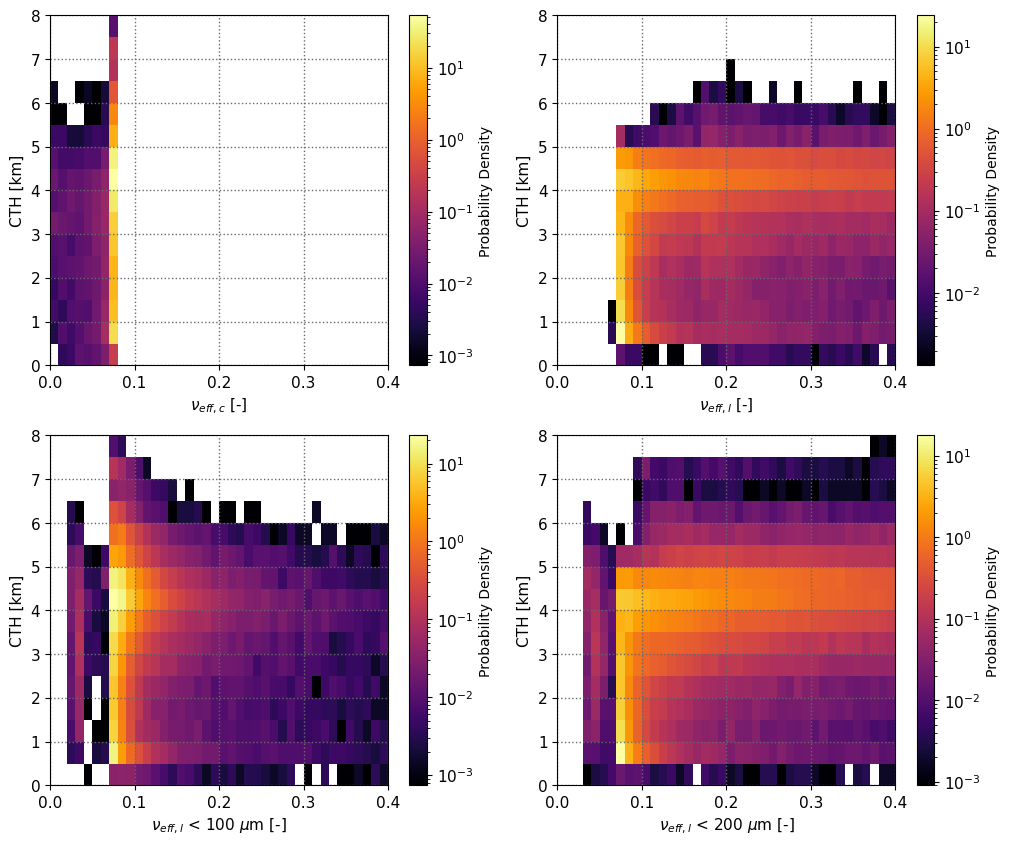

In [18]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
axlist =[ax1,ax2,ax3,ax4]
Fontsize=11
for ax in axlist:
    ax.grid(which='both',ls='dotted',lw=1,c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_ylabel('CTH [km]',fontsize=Fontsize)

cth_bins = np.arange(0,8.5,0.5)

veff_bins = np.arange(0,0.41,0.01)
tmpplot=ax1.hist2d(dum_veff_c_int,dum_cth,bins=[veff_bins,cth_bins],cmap='inferno',norm=matplotlib.colors.LogNorm(),density=True)
ax1.set_xlabel('$\\nu_{eff,c}$ [-]',fontsize=Fontsize)
cbar=fig.colorbar(tmpplot[3])
cbar.ax.tick_params(labelsize=Fontsize)
cbar.ax.set_ylabel('Probability Density')

tmpplot=ax2.hist2d(dum_veff_l,dum_cth,bins=[veff_bins,cth_bins],cmap='inferno',norm=matplotlib.colors.LogNorm(),density=True)
ax2.set_xlabel('$\\nu_{eff,l}$ [-]',fontsize=Fontsize)
cbar=fig.colorbar(tmpplot[3])
cbar.ax.tick_params(labelsize=Fontsize)
cbar.ax.set_ylabel('Probability Density')

tmpplot=ax3.hist2d(dum_veff_l_lt_100um,dum_cth,bins=[veff_bins,cth_bins],cmap='inferno',norm=matplotlib.colors.LogNorm(),density=True)
ax3.set_xlabel('$\\nu_{eff,l}$ < 100 $\\mu$m [-]',fontsize=Fontsize)
cbar=fig.colorbar(tmpplot[3])
cbar.ax.tick_params(labelsize=Fontsize)
cbar.ax.set_ylabel('Probability Density')

tmpplot=ax4.hist2d(dum_veff_l_lt_200um,dum_cth,bins=[veff_bins,cth_bins],cmap='inferno',norm=matplotlib.colors.LogNorm(),density=True)
ax4.set_xlabel('$\\nu_{eff,l}$ < 200 $\\mu$m [-]',fontsize=Fontsize)
cbar=fig.colorbar(tmpplot[3])
cbar.ax.tick_params(labelsize=Fontsize)
cbar.ax.set_ylabel('Probability Density')

plt.show()
plt.close()